In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import gc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot
import platform

import keras
from keras import layers
from keras import metrics
from keras.models import load_model
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras import models
from keras.models import Sequential
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications import VGG16
from keras.utils import plot_model

2023-08-28 16:06:12.669892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: module 'tensorflow.python.data.ops.from_tensor_slices_op' has no attribute '_TensorSliceDataset'

### Enable CUDA if OS is Windows

In [2]:
if platform.system() == 'Windows': 
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Set path and get all classes. ".DS_Store" needs to be removed on MacOS again

In [3]:
d = '/home/sebastian/Documents/Hauptprojekt/Daten_sorted/'
classes = (os.listdir(d))
if ".DS_Store" in classes:
    classes.remove(".DS_Store")
if "._.DS_Store" in classes:
    classes.remove("._.DS_Store")

In [4]:
print(classes)

['sales_order', 'purchase_order', 'utility_bill', 'debit_note', 'order', 'receipt', 'proforma', 'tax_invoice', 'credit_note']


In [2]:
print(tf.__version__)

NameError: name 'tf' is not defined

Global variables

In [5]:
img_size = 224
batch_size = 32
epochs = 100
mod_tax = 10
mod_order = 5
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 4321
channels = 3
learning_rate = 0.00001

Get all Data

In [6]:
total_set = []
total_labels = []
counter_tax = 0 
counter_order = 0

for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            label = root.split(os.path.sep)[-1]
            if label == "tax_invoice":
                counter_tax +=1
                if counter_tax % mod_tax == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            elif label == "order":
                counter_order +=1
                if counter_order % mod_order == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            else:    
                path = os.path.join(root, file)
                total_set.append(path)
                total_labels.append(label)
            

# Return image class based on list entry (path)         
def getClass(img):
    return img.split(os.path.sep)[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-052(1).jpg
GetClass :  sales_order
Label :  sales_order


In [7]:
len(total_set)

19395

In [8]:
img = mpimg.imread("/home/sebastian/Documents/Hauptprojekt/Daten_sorted/debit_note/2aeea3060ec34935b5a2a6e9(2).jpg")

Plot random samples

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-60342157e5654d1292205df4-813(1).jpg


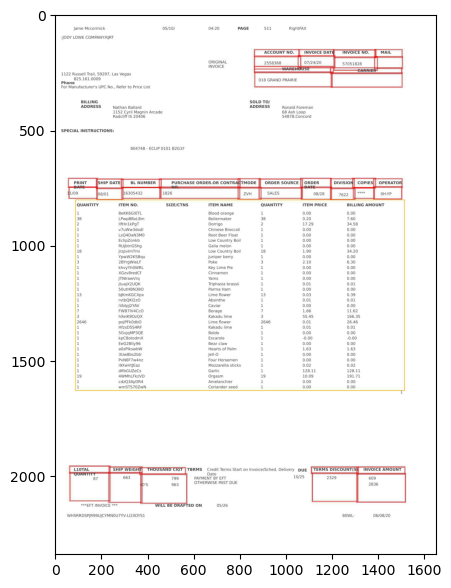

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/receipt/synthetic-410651d35003486c860e6985-120(1).jpg


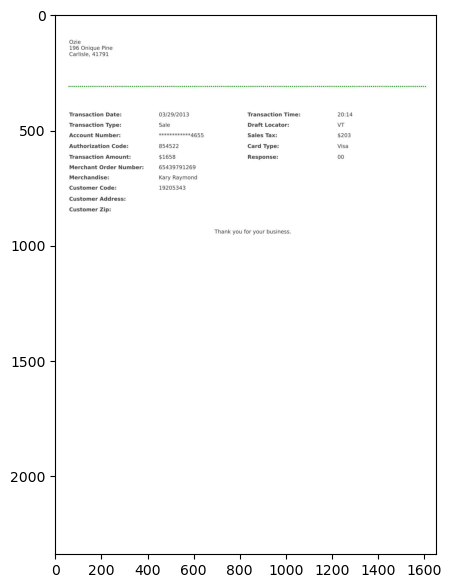

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-1c5cf2840ec745479b53bcad-958(1).jpg


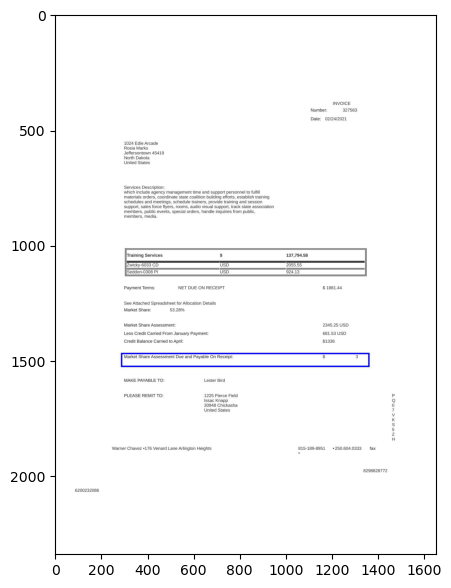

In [9]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = mpimg.imread(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()

Sorting the data in test, train and validation sets


In [10]:
# Get data and separate it in sets
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))

    
index = int(total_len*train_size)+1
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)+1 

for i in total_set[index: total_len] :
    test_set.append(i)
    test_label.append(getClass(i))

print(train_set[750])
print(train_label[750])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-f660a970247647439670abb7-533(1).jpg
tax_invoice


Visualizing class distribution for each set

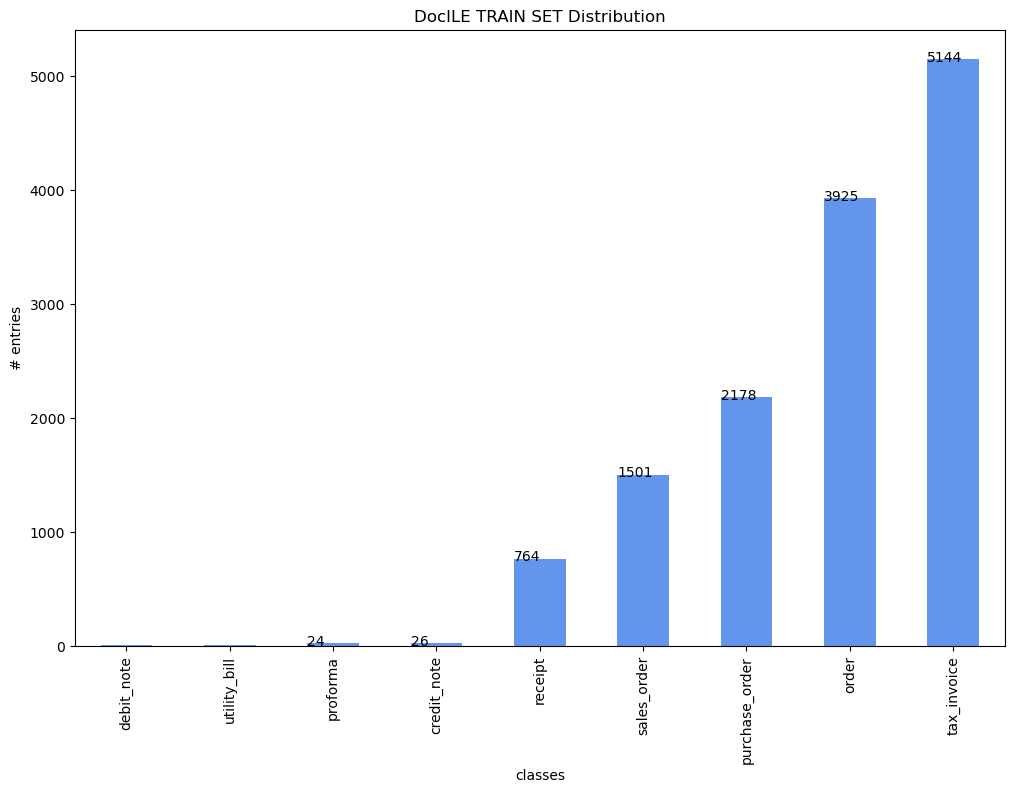

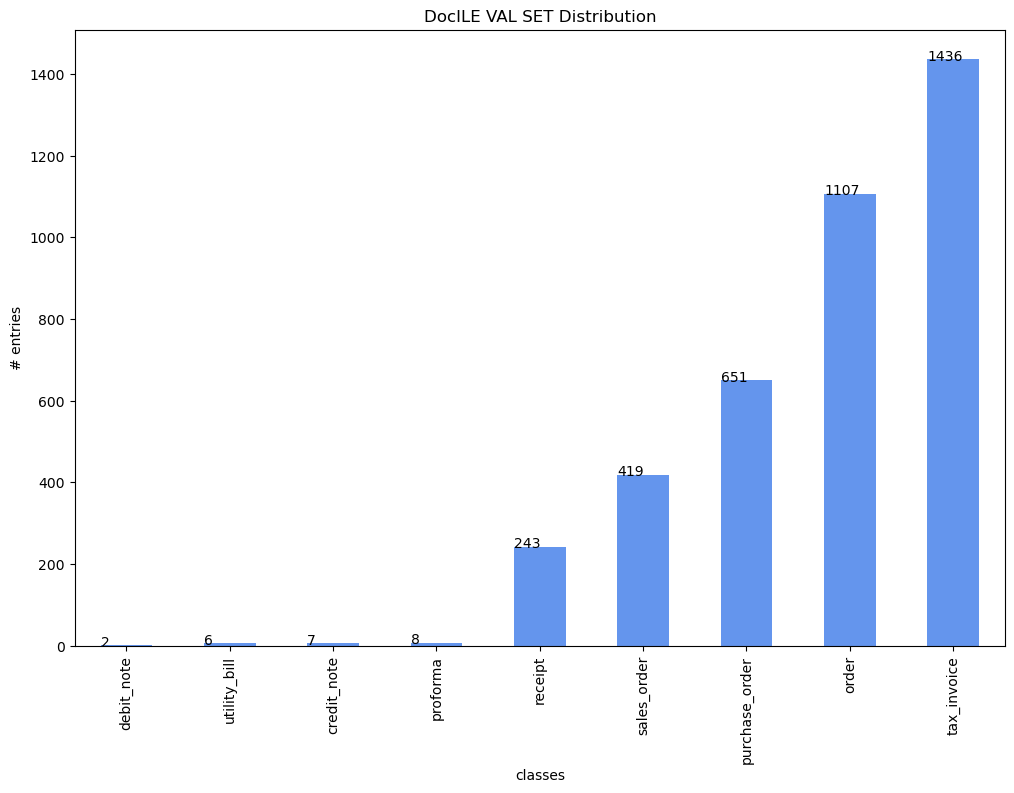

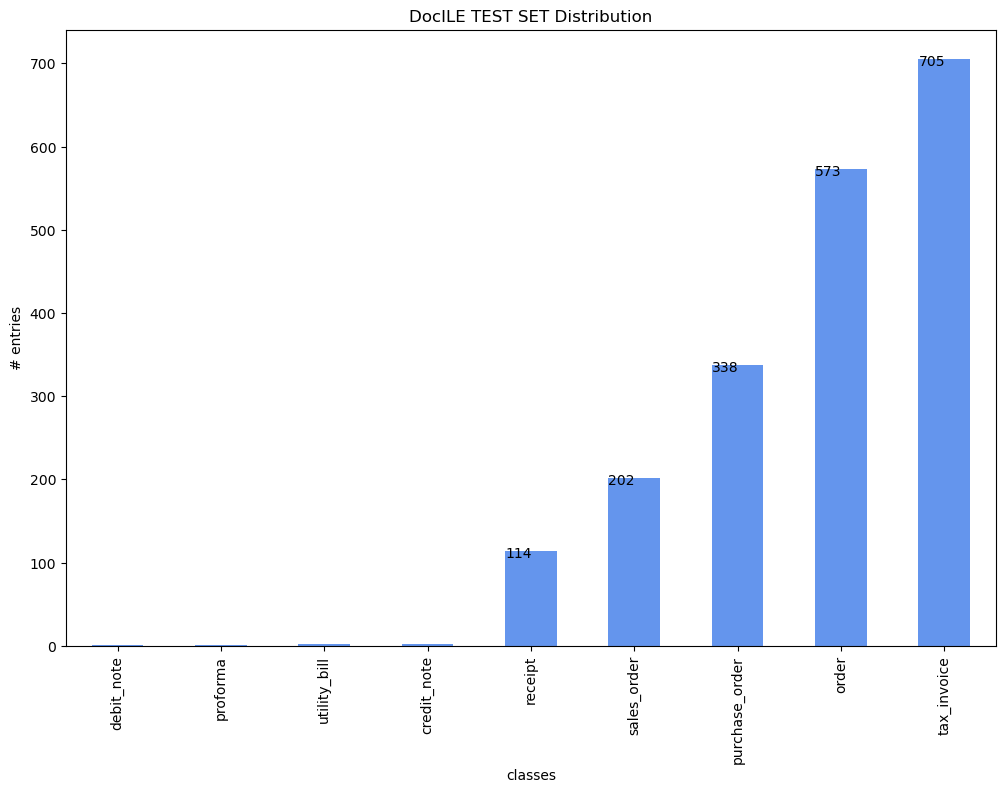

In [11]:
#################################################
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TRAIN SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

#################################################
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE VAL SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))
    
#################################################
# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TEST SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-8))

Preprocess data (resize, transform to Numpy array and binarize)

In [114]:
def process_images(img_set) : 
    processed_img = []
    counter = 0

    for i in range(len(img_set)):
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
 
    return processed_img
    
data_train = process_images(train_set)

In [115]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
            processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))    
    
    return processed_img
    
data_test = process_images(test_set)

In [116]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
              processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
        
    return processed_img
    
data_val = process_images(val_set)

In [117]:
test_set[200]

'/home/sebastian/Documents/Hauptprojekt/Daten_sorted/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-162(1).jpg'

In [118]:
test_label[200]

'sales_order'

In [119]:
y_test[200]

array([0, 0, 0, 0, 0, 0, 1, 0, 0])

In [120]:
list(classes)

['sales_order',
 'purchase_order',
 'utility_bill',
 'debit_note',
 'order',
 'receipt',
 'proforma',
 'tax_invoice',
 'credit_note']

In [12]:
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(data_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(data_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(data_val)
y_val = lb.transform(np.array(val_label))

print("train images shape : ", x_train.shape)
print("train labels shape : ", y_train.shape)
print(x_train[0])

print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)


for i in range(3) :
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(x_train[i])


print(train_label[0])
print(y_train[0])
print(lb.classes_)

NameError: name 'data_train' is not defined

In [122]:
len(x_train)

13576

Save the sets to .npy file for use after restarting runtime

In [123]:
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_train.npy', x_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_test.npy', x_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_train.npy', y_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_test.npy', y_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_val.npy', x_val)
np.save('//home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_val.npy', y_val)

load sets after restarting runtime

In [6]:
x_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_train.npy')
x_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_test.npy')
y_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_train.npy')
y_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_test.npy')
x_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/x_val.npy')
y_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/VGG16/y_val.npy')

### Load Model

With "layer.trainable = False" you can freeze the layers of the base model. That means when your training the model that you only train the layers added to the base model. Training the whole model takes about three to four times longer for training since there are way more parameters to train.

For this project two models were testet. One with "layer.trainable = False" and one without it. 

In [7]:
base_model = VGG16(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

for layer in base_model.layers:
    layer.trainable = False
    
if layer.trainable == False:
    name_layer = "_added_layer_"
elif layer.trainable == True:
    name_layer = "_all_layer_"
    
base_model.summary()

2023-08-28 14:11:01.779461: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1051 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Create custom model

Base is VGG16, adding a flatten layer, a Dense layer and a dropout layer. Last Dense layer specify the number of classes

In [8]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu',  name='dense'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

model.summary()

print('Number of trainable weights : ', len(model.trainable_weights))

plot_model(model, to_file='model_VGG-16.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 9)                 1161      
                                                                 
Total params: 17927241 (68.39 MB)
Trainable params: 3212553 (12.25 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Number of

In [9]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Training the model with DocILE Data. Only the last added layers are trained

Compile : Configures the model for training.

Fit : Trains the model for a given number of epochs

https://keras.io/models/model/

In [10]:
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', f1_m,keras.metrics.Precision(), keras.metrics.Recall()])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val))

2023-08-28 14:11:18.009020: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.90GiB (rounded to 2043568128)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-08-28 14:11:18.009086: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-08-28 14:11:18.009111: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 32, Chunks in use: 32. 8.0KiB allocated for chunks. 8.0KiB in use in bin. 672B client-requested in use in bin.
2023-08-28 14:11:18.009127: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 3, Chunks in use: 3. 1.5KiB allocated for chunks. 1.5KiB in use in bin. 1.5KiB client-requested in use in bin.
2023-08-28 14:11:18.009140: I tensorflow/tsl/framework/bfc_

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [17]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)

Plot accuracy and loss of trained model

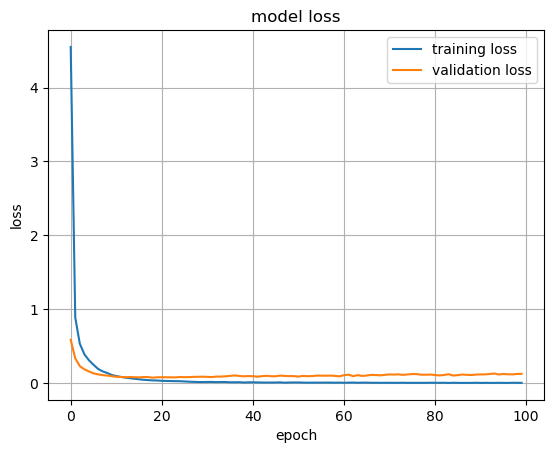

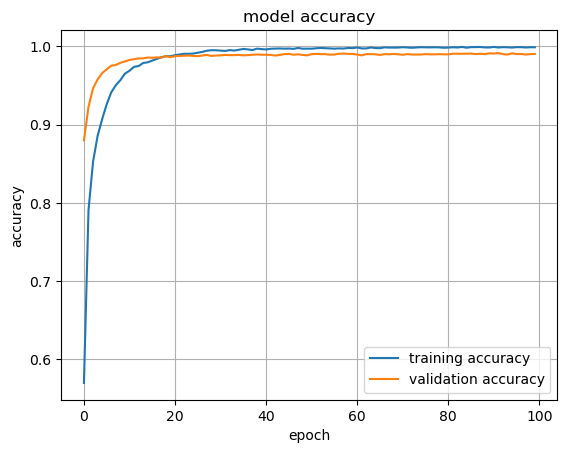

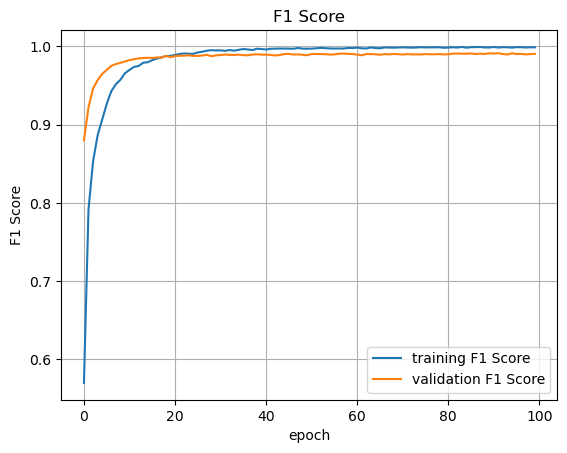

In [18]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/VGG16/model_loss_added_layer_' + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()


plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/VGG16/model_acc_added_layer_' + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()


plt.plot(train_model.history['f1_m'])
plt.plot(train_model.history['val_f1_m'])
plt.title('F1 Score')
plt.grid()
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['training F1 Score', 'validation F1 Score'], loc='lower right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/VGG16/F1_added_layer_' + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

Test prediction accuracy on test set

In [19]:
# combine predictions + average for better score ? 

score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

61/61 [==============================] - 2s 39ms/step - loss: 0.0811 - accuracy: 0.9897 - f1_m: 0.9895 - precision_m: 0.9898 - recall_m: 0.9892
Test loss: 0.08114168792963028
Test accuracy: 0.9896801114082336


Save Model with trained last layers

In [3]:
model.save('/home/sebastian/Documents/Hauptprojekt/Models/VGG16/trained_model_added_layer_' + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.h5')

NameError: name 'model' is not defined

Use Model on test set

In [21]:
lb = LabelBinarizer()
lb.fit(list(classes))

false_pred = []
true_pred = []

predictions=model.predict(x_test) 
predictions_list = predictions.tolist()
predicted_classes=np.argmax(predictions,axis=1)



count_true = 0
count_false = 0

for i, prediction in enumerate(predictions_list):
    print(i)
    state = True
    print(prediction)#
    print("hallo:" ,predicted_classes[i])
    if (lb.classes_[predicted_classes[i]] != test_label[i]) :
        state = False
        count_false += 1
        false_pred.append(test_label[i])
    else :
        true_pred.append(test_label[i])
        count_true += 1
    print("Prediction : ", classes[predicted_classes[i]], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

61/61 [==============================] - 2s 36ms/step
0
[1.8605146209523885e-38, 2.7075107787868162e-36, 3.260738502593541e-22, 0.0, 3.493125983302689e-38, 6.773704136575361e-37, 2.540406945850976e-36, 1.0, 5.854981384595308e-36]
hallo: 7
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
1
[1.623791911918766e-15, 1.2894709171956675e-12, 1.0, 2.0110059298551362e-15, 3.454803785174661e-14, 3.261596078125723e-15, 1.469119354706276e-14, 1.4276368975885134e-10, 2.938665625598497e-18]
hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
2
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.7161154239151443e-35, 1.7177579822577424e-29, 0.0]
hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
3
[1.1670025044003089e-29, 3.0579024162064867e-30, 6.656875566248859e-20, 2.13846082610469e-37, 6.661922580686356e-30, 3.3972050336462255e-24, 8.409527337784065e-35, 1.0, 8.665133648212453e-34]
hallo: 7
Prediction :  tax_invoice 

hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
1021
[6.323059365535655e-24, 8.378861452901689e-25, 2.414702915337155e-23, 0.0, 1.0, 1.0427603469292232e-35, 1.1585180005862432e-28, 3.0887040395003694e-20, 2.0411178583384367e-29]
hallo: 4
Prediction :  order    |   Real class :  purchase_order    |   Result :  True
1022
[7.782468047128927e-20, 1.1511586380408543e-17, 1.0, 2.330120669354188e-16, 2.641519726179696e-17, 6.263028697007719e-14, 5.918275847794144e-16, 3.8041496493688987e-14, 6.793603472794081e-22]
hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
1023
[2.243088700892848e-11, 2.0318724133772115e-11, 1.0, 6.659963379396228e-12, 4.96593988152938e-10, 4.962271660247097e-08, 2.271140393805826e-11, 7.622484865521528e-09, 2.9464054622767993e-14]
hallo: 2
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
1024
[7.037333977038999e-22, 6.315165316498642e-20, 1.4289987623481269e-18, 1.199199

Print wrong classifications per class

In [22]:
print(f'"debit_note" was classified wrong {false_pred.count("debit_note")} time(s) out of {false_pred.count("debit_note") + true_pred.count("debit_note")} time(s)')
print(f'"proforma" was classified wrong {false_pred.count("proforma")} time(s) out of {false_pred.count("proforma") + true_pred.count("proforma")} time(s)')
print(f'"utility_bill" was classified wrong {false_pred.count("utility_bill")} time(s) out of {false_pred.count("utility_bill") + true_pred.count("utility_bill")} time(s)')
print(f'"credit_note" was classified wrong {false_pred.count("credit_note")} time(s) out of {false_pred.count("credit_note") + true_pred.count("credit_note")} time(s)')
print(f'"receipt" was classified wrong {false_pred.count("receipt")} time(s) out of {false_pred.count("receipt") + false_pred.count("receipt")} time(s)')
print(f'"sales_order" was classified wrong {false_pred.count("sales_order")} time(s) out of {false_pred.count("sales_order") + true_pred.count("sales_order")} time(s)')
print(f'"purchase_order" was classified wrong {false_pred.count("purchase_order")} time(s) out of {false_pred.count("purchase_order") + true_pred.count("purchase_order")} time(s)')
print(f'"order" was classified wrong {false_pred.count("order")} time(s) out of {false_pred.count("order") + true_pred.count("order")} time(s)')
print(f'"tax_invoice" was classified wrong {false_pred.count("tax_invoice")} time(s) out of {false_pred.count("tax_invoice") + true_pred.count("tax_invoice")} time(s)')

"debit_note" was classified wrong 1 time(s) out of 1 time(s)
"proforma" was classified wrong 0 time(s) out of 1 time(s)
"utility_bill" was classified wrong 1 time(s) out of 2 time(s)
"credit_note" was classified wrong 1 time(s) out of 2 time(s)
"receipt" was classified wrong 6 time(s) out of 12 time(s)
"sales_order" was classified wrong 1 time(s) out of 202 time(s)
"purchase_order" was classified wrong 1 time(s) out of 338 time(s)
"order" was classified wrong 6 time(s) out of 573 time(s)
"tax_invoice" was classified wrong 3 time(s) out of 705 time(s)


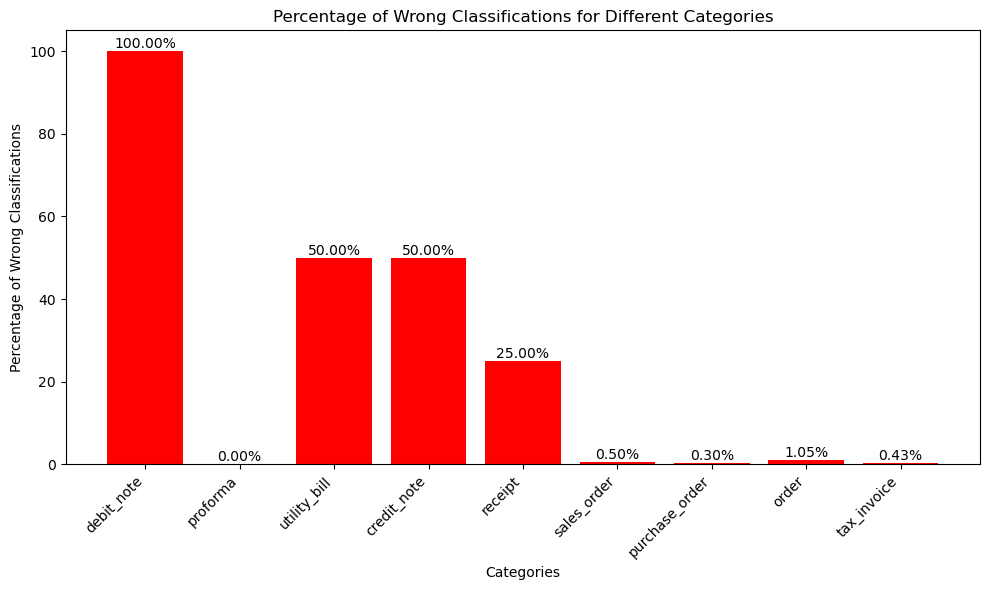

In [1]:
import matplotlib.pyplot as plt

# Data
categories = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

wrong_counts = [
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("proforma"),  # proforma
    false_pred.count("utility_bill"),  # utility_bill
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("order"), # order
    false_pred.count("tax_invoice")  # tax_invoice
]

total_counts = [
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("utility_bill") + true_pred.count("utility_bill"),   # utility_bill
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice")  # tax_invoice
]

# Calculate percentage of wrong classifications
wrong_percentages = [wrong / total * 100 for wrong, total in zip(wrong_counts, total_counts)]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, wrong_percentages, color='red')
plt.xlabel('Categories')
plt.ylabel('Percentage of Wrong Classifications')
plt.title('Percentage of Wrong Classifications for Different Categories')
plt.xticks(rotation=45, ha='right')

# Add numbers to the bars
for bar, wrong_percentage in zip(bars, wrong_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{wrong_percentage:.2f}%',
        ha='center',
        va='bottom',
        color='black',
        fontsize=10
    )

plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/VGG16/Classification_added_layer_' + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()

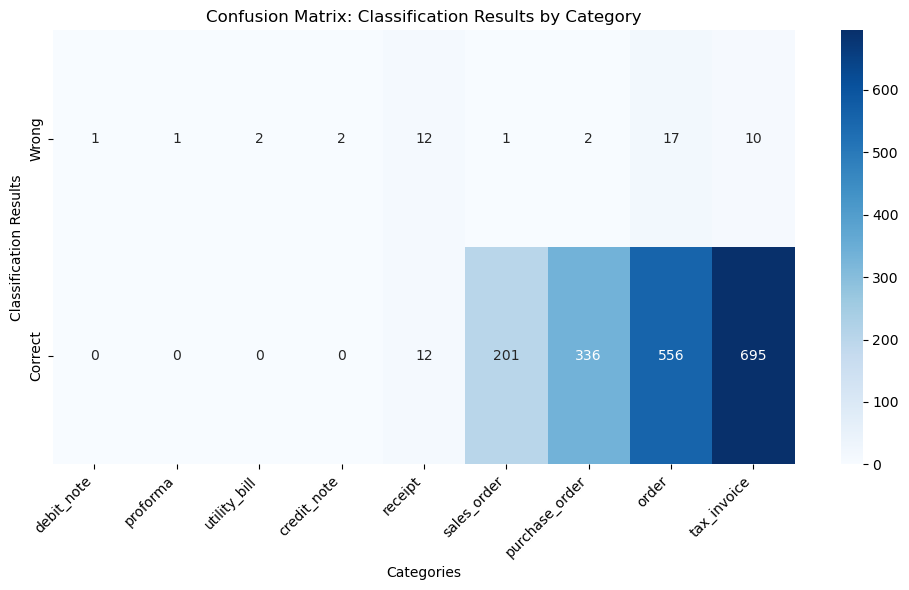

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define categories and data
categories = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

wrong_counts = [
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("proforma"),  # proforma
    false_pred.count("utility_bill"),  # utility_bill
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("order"), # order
    false_pred.count("tax_invoice")  # tax_invoice
]
wrong_counts = np.array(wrong_counts)

total_counts = [
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("utility_bill") + true_pred.count("utility_bill"),   # utility_bill
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice")  # tax_invoice
]
total_counts = np.array(total_counts)

# Calculate percentage of wrong classifications
wrong_percentages = wrong_counts / total_counts * 100

# Create a confusion matrix
confusion_matrix = np.vstack((wrong_counts, total_counts - wrong_counts))

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=categories, yticklabels=['Wrong', 'Correct'])
plt.xlabel('Categories')
plt.ylabel('Classification Results')
plt.title('Confusion Matrix: Classification Results by Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/VGG16/confusion_matrix_added_layer_' + str(epochs) + 'epochs_' + str(mod_tax) + '_' + str(mod_order) + '.png')
plt.show()